In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import numpy as np
import cv2
import os
import glob
import random
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
#Global Feature Parameters
orient = 10
pix_per_cell = 8
cell_per_block = 2
cspace = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

Test Image 1
Dimension: (720, 1280, 3)


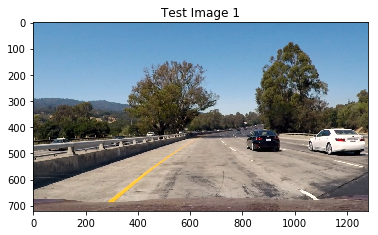

In [3]:
allImages = []

#Read all Calibration Images
allImageNames = glob.glob('test_images/test*.jpg')

for imgName in allImageNames:
    im = mpimg.imread(imgName)
    allImages.append(im)

testImage1 = allImages[0]
print("Test Image 1")
print("Dimension:",testImage1.shape)
plt.title("Test Image 1")
plt.imshow(testImage1)

In [4]:
def color_hist(img, nbins, bins_range):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features

In [5]:
def bin_spatial(img, size):
    features = cv2.resize(img, size).ravel() 
    return features

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, cspace,feature_vec):                

    if len(img.shape) == 2: # Only single Channel Image
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block),block_norm= 'L2-Hys',transform_sqrt=False, visualise=False, feature_vector=feature_vec)
        return features
    else: # 3 Channels
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)          
        ch1 = hog(feature_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys', transform_sqrt=False, visualise = False, feature_vector = feature_vec).ravel() 
        ch2 = hog(feature_image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys', transform_sqrt=False, visualise = False, feature_vector = feature_vec).ravel() 
        ch3 = hog(feature_image[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys', transform_sqrt=False, visualise = False, feature_vector = feature_vec).ravel() 
        return np.hstack((ch1, ch2, ch3))

In [7]:
def extract_features(image, cspace, spatial_size, hist_bins, hist_range):
    # Create a list to append feature vectors to

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
      
    return np.concatenate((spatial_features, hist_features))

Amount of Vehicles Picture is: 8792
Amount of Non - Vehicles Picture is: 8968


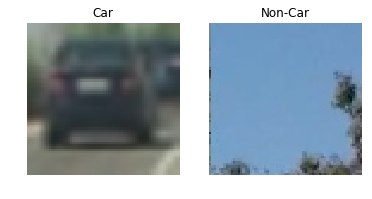

In [8]:
# Read Training Data
vehicleFiles = []
vehCount = 0
exampleVehImage = None

non_vehiclesFiles = []
nonVehCount = 0
exampleNonVehImage = None

vehiclesFile = "Training_Data/vehicles"
nonVehiclesFile = "Training_Data/non-vehicles"

for vehFile in glob.iglob(vehiclesFile + '/**/*.png', recursive=True):
    vehicleFiles.append(vehFile)
    if vehCount == 0:
        exampleVehImage = mpimg.imread(vehFile)
    vehCount+=1
print('Amount of Vehicles Picture is:',vehCount)

for nonVehFile in glob.iglob(nonVehiclesFile + '/**/*.png', recursive=True):
    non_vehiclesFiles.append(nonVehFile)
    if nonVehCount == 0:
        exampleNonVehImage = mpimg.imread(nonVehFile)
    nonVehCount+=1
print('Amount of Non - Vehicles Picture is:',nonVehCount)

fig=plt.figure() 
fig.add_subplot(1,2, 1)
plt.imshow(exampleVehImage)
plt.title('Car')
plt.axis('off')
          
fig.add_subplot(1,2, 2)
plt.imshow(exampleNonVehImage)
plt.title('Non-Car')
plt.axis('off')

plt.show()

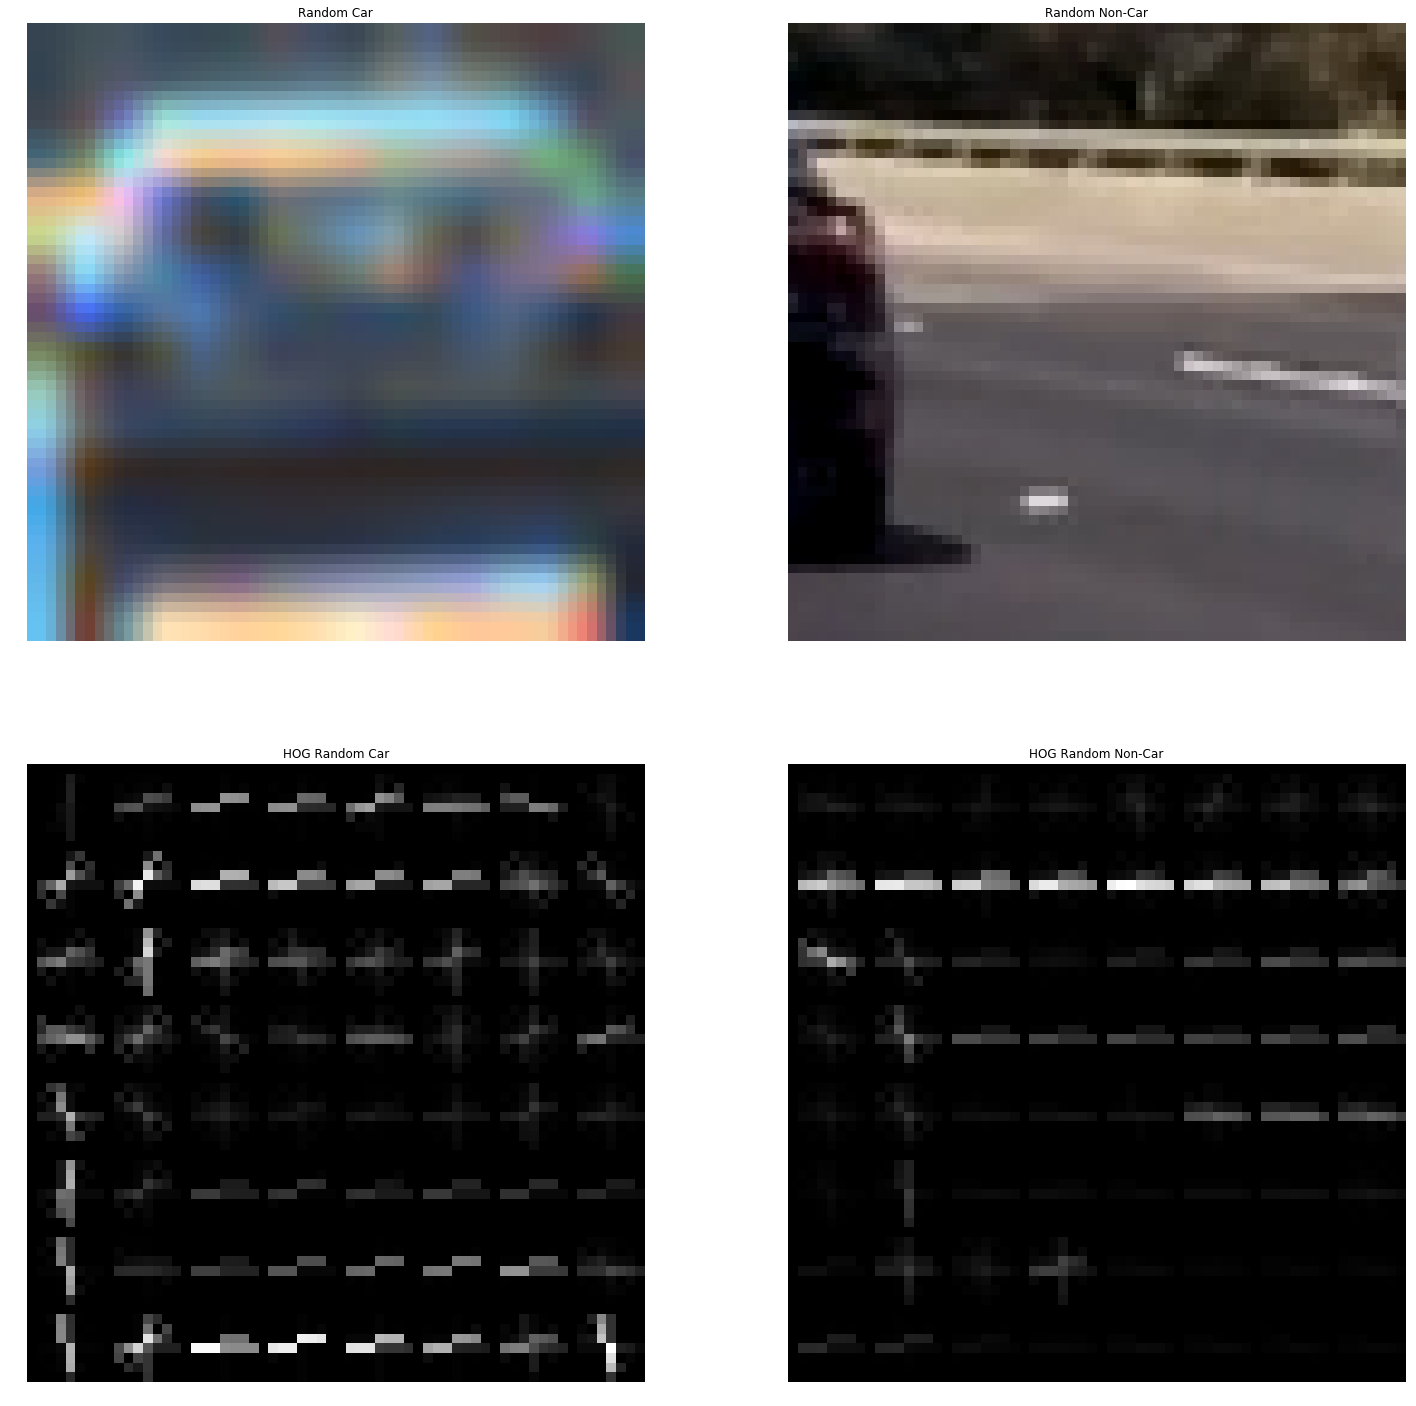

In [9]:
# HOG Visualization

randomCarImg = mpimg.imread(vehicleFiles[random.randint(0,vehCount+1)])
randomNonCarImg =  mpimg.imread(non_vehiclesFiles[random.randint(0,nonVehCount+1)])

fig=plt.figure(figsize=(25,25)) 

fig.add_subplot(2,2,1)
plt.imshow(randomCarImg)
plt.title('Random Car')
plt.axis('off')
          
fig.add_subplot(2,2,2)
plt.imshow(randomNonCarImg)
plt.title('Random Non-Car')
plt.axis('off')

fig.add_subplot(2,2,3)
randomCarImg_Gray = cv2.cvtColor(randomCarImg, cv2.COLOR_RGB2GRAY)
hog_features, hog_image_car = hog(randomCarImg_Gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),block_norm= 'L2-Hys', transform_sqrt = False, visualise= True, feature_vector = True) 
plt.imshow(hog_image_car,cmap='gray')
plt.title('HOG Random Car')
plt.axis('off')
          
fig.add_subplot(2,2,4)
randomNonCarImg_Gray = cv2.cvtColor(randomNonCarImg, cv2.COLOR_RGB2GRAY)
hog_features, hog_image_Ncar = hog(randomNonCarImg_Gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),block_norm= 'L2-Hys', transform_sqrt = False, visualise= True, feature_vector = True)
plt.imshow(hog_image_Ncar,cmap='gray')
plt.title('HOG Random Non-Car')
plt.axis('off')

plt.show()

In [10]:
def combineAllFeatures(img, orient, pix_per_cell, cell_per_block, cspace, spatial_size ,hist_bins, hist_range):
    hogFeatures = get_hog_features(img, orient, pix_per_cell, cell_per_block, cspace, feature_vec = False)
    colorFeatures = extract_features(img, cspace, spatial_size ,hist_bins, hist_range)
    return np.concatenate((hogFeatures, colorFeatures))

In [11]:
car_features = []
notcar_features = []

counter = 0

print("Feature Extraction for Cars starts..")
for vehFile in vehicleFiles:
    if (counter % 1000 == 0): print(counter) 
    imgToGetFeatures = mpimg.imread(vehFile)
    feature = combineAllFeatures(imgToGetFeatures, orient, pix_per_cell, cell_per_block, cspace, spatial_size ,hist_bins, hist_range)
    car_features.append(feature)
    counter = counter +1
print("Feature Extraction for Cars finished!")
  
counter = 0
print("Feature Extraction for Non-Cars starts..")   
for nonVehFile in non_vehiclesFiles:
    if (counter % 1000 == 0): print(counter)
    imgNToGetFeatures = mpimg.imread(nonVehFile)
    feature = combineAllFeatures(imgNToGetFeatures, orient, pix_per_cell, cell_per_block, cspace, spatial_size ,hist_bins, hist_range)
    notcar_features.append(feature)
    counter = counter +1
print("Feature Extraction for Non-Cars finished!")   

Feature Extraction for Cars starts..
0
1000
2000
3000
4000
5000
6000
7000
8000
Feature Extraction for Cars finished!
Feature Extraction for Non-Cars starts..
0
1000
2000
3000
4000
5000
6000
7000
8000
Feature Extraction for Non-Cars finished!


In [12]:
print("An Image has",len(car_features[0]), "amount of features!")

An Image has 9048 amount of features!


In [13]:
#Data Creation

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))

In [14]:
# Training Model
X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9828


In [15]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, boxColor = (0,255,0)):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = img_tosearch   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, cspace = None, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, cspace = None, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, cspace = None, feature_vec=False)
    
    box_list = []   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
             
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, hist_bins, hist_range)
                      
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),boxColor,6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            if test_prediction == 0 and False: # For checking the coverage area of y start and stop
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,255,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, box_list

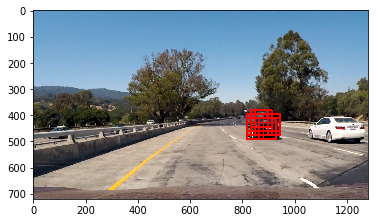

In [16]:
# 1 - XX Small Scales
ystart = 380
ystop = 500
scale = 1.0
color = (255,0,0)
out_img, box_list_XXS = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

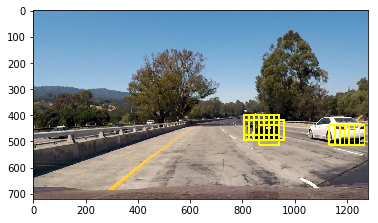

In [17]:
# 2 - X Small Scales
ystart = 400
ystop = 550
scale = 1.2
color = (255,255,0)
out_img, box_list_XS = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

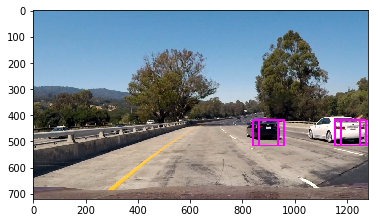

In [18]:
# 3 - Small Scales
ystart = 420
ystop = 556
scale = 1.5
color = (255,0,255)
out_img, box_list_S = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

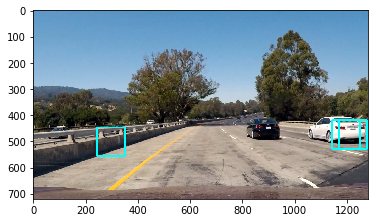

In [19]:
# 4 - Medium Scales
ystart = 420
ystop = 600
scale = 1.7
color = (0,255,255)
out_img, box_list_M = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

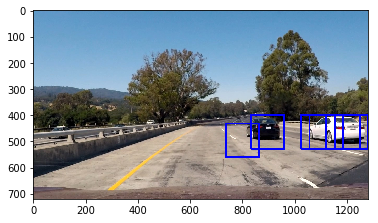

In [20]:
# 5 - Large Scales
ystart = 400
ystop = 590
scale = 2.0
color = (0,0,255)
out_img, box_list_L = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

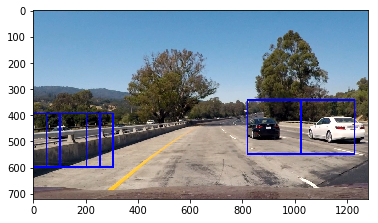

In [21]:
# 6 - X Large Scales
ystart = 343
ystop = 700
scale = 3.2
out_img, box_list_XL = find_cars(testImage1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range, color)
plt.imshow(out_img)

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [23]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [24]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

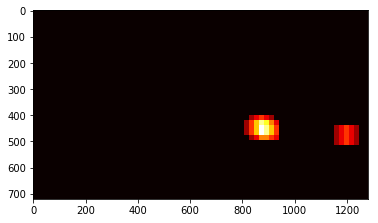

In [25]:
heat = np.zeros_like(testImage1[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list_XS)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

plt.imshow(heatmap, cmap='hot')

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

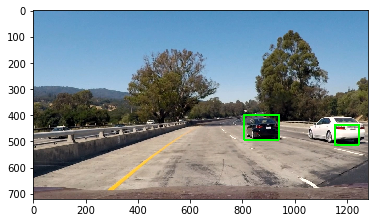

In [27]:
draw_img = draw_labeled_bboxes(np.copy(testImage1), labels)
# Display the image
plt.imshow(draw_img)

In [28]:
def detectCars(img):
    
    # 1 %%%%%%%%%%%%%%%%%%%%
    ystart = 380
    ystop = 500
    scale = 1.0
    out_img_1, box_list_1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)

    # 2 %%%%%%%%%%%%%%%%%%%%
    ystart = 400
    ystop = 520
    scale = 1.0
    out_img_2, box_list_2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
    
    # 3 %%%%%%%%%%%%%%%%%%%%
    ystart = 400
    ystop = 550
    scale = 1.5
    out_img_3, box_list_3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
    
    # 4 %%%%%%%%%%%%%%%%%%%%
    ystart = 410
    ystop = 560
    scale = 1.3
    out_img_4, box_list_4 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)

    # 5 %%%%%%%%%%%%%%%%%%%%
    ystart = 400
    ystop = 590
    scale = 2.0
    out_img_5, box_list_5 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
    
    # 6 %%%%%%%%%%%%%%%%%%%%
    ystart = 450
    ystop = 640
    scale = 2.0
    out_img_6, box_list_6 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
    
    # 7 %%%%%%%%%%%%%%%%%%%%
    ystart = 420
    ystop = 660
    scale = 3.3
    out_img_7, box_list_7 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
        
    # 8 %%%%%%%%%%%%%%%%%%%%
    ystart = 343
    ystop = 700
    scale = 3.2
    out_img_8, box_list_8 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hist_range)
        
    box_list = box_list_1 + box_list_2 + box_list_3 + box_list_4 + box_list_5 + box_list_6 + box_list_7 + box_list_8
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,18) 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

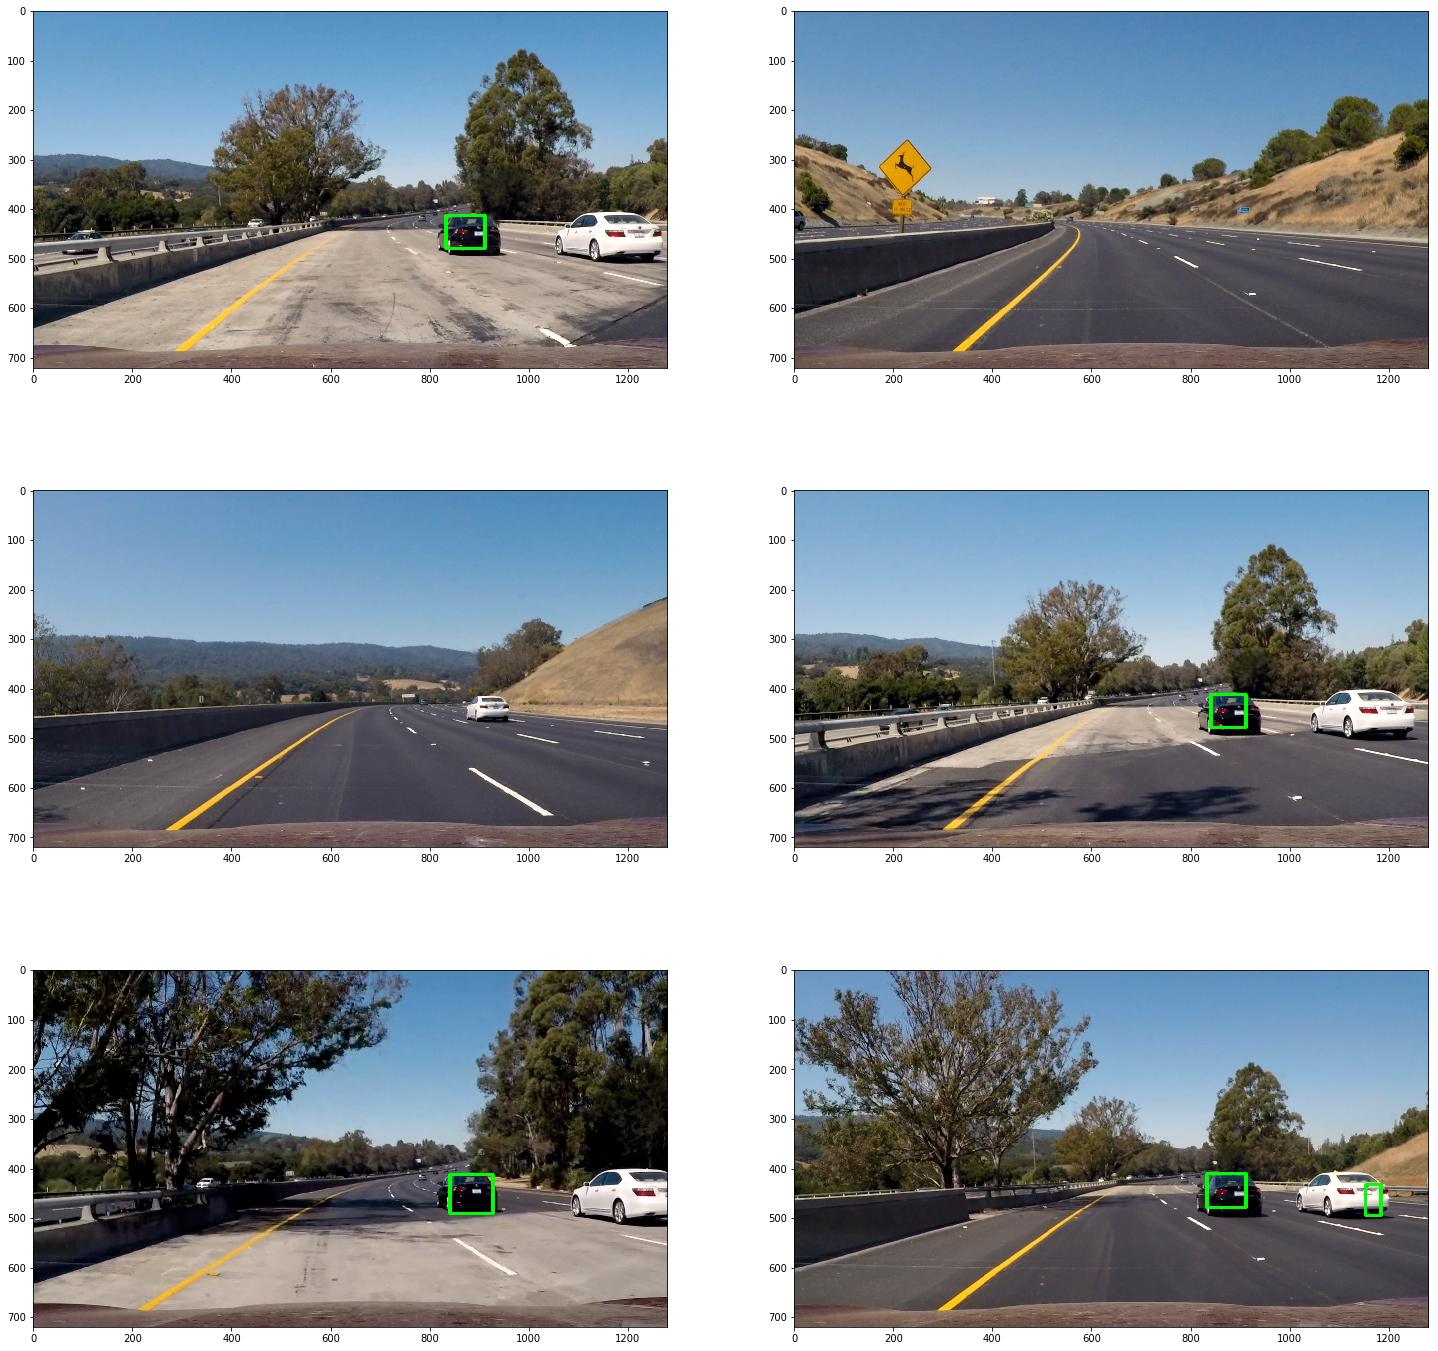

In [29]:
siz = len(allImages)
i = 1
fig=plt.figure(figsize=(25,25)) 

for testIm in allImages:
    fig.add_subplot(siz/2,2,i)
    detectedIm = detectCars(testIm)
    plt.imshow(detectedIm)
    i = i+1
    
plt.show()

In [30]:
if False:
    clip1 = VideoFileClip("test_video.mp4")
    my_clip = clip1.fl_image(detectCars)
    %time my_clip.write_videofile('test_video_output.mp4', audio=False)

In [31]:
if False:
    clip1 = VideoFileClip("project_video.mp4")
    my_clip = clip1.fl_image(detectCars)
    %time my_clip.write_videofile('project_video_output.mp4', audio=False)